In [23]:
from google.colab import drive
import pandas as pd
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

df = pd.read_csv('Steam Sentiment Analysis.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
df['is_positive'] = df['is_positive'].apply(lambda x: 1 if x == 'Negative' else 0)

In [25]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if word not in stop_words]
        return " ".join(filtered_words)
    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    if isinstance(text, str):
        words = text.split()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return " ".join(lemmatized_words)
    return text

df['content'] = df['content'].apply(preprocess_text)
df['content'] = df['content'].apply(remove_stopwords)
df['content'] = df['content'].apply(lemmatize_text)

In [26]:
X = df['content']
y = keras.utils.to_categorical(df['is_positive'], num_classes=2)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = X_train.astype(str), X_test.astype(str)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

model = Sequential()
model.add(Embedding(5000, 128, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4526/4526 ━━━━━━━━━━━━━━━━━━━━ 58s 12ms/step - accuracy: 0.7886 - loss: 0.4337 - val_accuracy: 0.8282 - val_loss: 0.3646
Epoch 2/5
4526/4526 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - accuracy: 0.8387 - loss: 0.3433 - val_accuracy: 0.8360 - val_loss: 0.3544
Epoch 3/5
4526/4526 ━━━━━━━━━━━━━━━━━━━━ 87s 13ms/step - accuracy: 0.8541 - loss: 0.3148 - val_accuracy: 0.8358 - val_loss: 0.3581
Epoch 4/5
4526/4526 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - accuracy: 0.8662 - loss: 0.2951 - val_accuracy: 0.8359 - val_loss: 0.3662
Epoch 5/5
4526/4526 ━━━━━━━━━━━━━━━━━━━━ 89s 14ms/step - accuracy: 0.8743 - loss: 0.2745 - val_accuracy: 0.8346 - val_loss: 0.3764


              precision    recall  f1-score   support

           0       0.81      0.87      0.84     20592
           1       0.85      0.79      0.82     19639

    accuracy                           0.83     40231
   macro avg       0.83      0.83      0.83     40231
weighted avg       0.83      0.83      0.83     40231



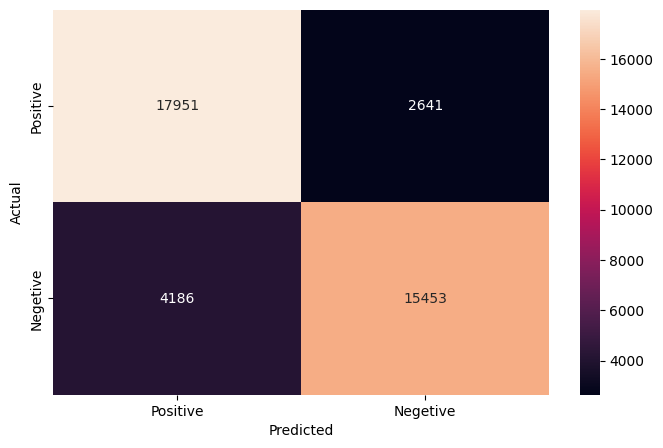

In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = np.argmax(y_test, axis = 1)
pred = np.argmax(model.predict(X_test_pad, verbose=0), axis = 1)

print(classification_report(y_true, pred))

cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Positive', 'Negetive'], yticklabels = ['Positive', 'Negetive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()